# Hedditch Authentication and Data Loading

In [ ]:
import requests
import pandas as pd
import os

In [ ]:
# personal use script, secret token
auth = requests.auth.HTTPBasicAuth( 'JNpGyLI-oJ_drb93Dykw9g', 'KgImJaXURcpJG4Ud9-HLBsj8UnnnRQ' )

data = {'grant_type': 'password',
        'username': 'shawwquille_aww_neal',
        'password': 'rampat11' }

headers = {'User-Agent': 'SquatBotTUM/0.0.1' }

res = requests.post( 'https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers )

token1 = res.json()['access_token']

headers = {**headers, **{'Authorization': f"bearer {token1}"}}

requests.get( 'https://oauth.reddit.com/api/v1/me', headers=headers )

<Response [200]>

In [ ]:
params = {'limit': 100}

res = requests.get( "https://oauth.reddit.com/r/stopdrinking/new", headers=headers, params=params )

print( res.json() )

{'kind': 'Listing', 'data': {'after': 't3_v49tl9', 'dist': 100, 'modhash': None, 'geo_filter': '', 'children': [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'stopdrinking', 'selftext': 'After drinking at least a fifth per day for over 6 years and more like a handle per day the last 2 of those years i found myself circling the drain in January. My liver was failing, I was vomiting daily,and my eyes turned yellow. For whatever reason those eyes were the final  straw and I decided to get sober. I’m down 70 fucking pounds since January and my liver numbers are way down as well. I know I have done some irreversible damage but I’m just grateful that I’m still here and still fighting this battle. Lurking on this sub has been a great motivator and I’m thankful for all of you', 'author_fullname': 't2_g7otj', 'saved': False, 'mod_reason_title': None, 'gilded': 0, 'clicked': False, 'title': '135 days', 'link_flair_richtext': [], 'subreddit_name_prefixed': 'r/stopdrinking', 'hidde

In [ ]:
def build_df( response ):
  
  df = pd.DataFrame()
  
  for post in res.json()['data']['children']:
    df = df.append({
        'subreddit': post['data']['subreddit'],
        'title': post['data']['title'],
        'selftext': post['data']['selftext'],
        'kind': post['kind'],
        'id': post['data']['id'],
        'upvote_ratio': post['data']['upvote_ratio'],
        'ups': post['data']['ups'],
        'downs': post['data']['downs'],
        'score': post['data']['score']
        }, ignore_index=True )
    
  return df

In [ ]:
df = pd.DataFrame()
num_passes = 10

for i in range( num_passes ):
  res = requests.get( "https://oauth.reddit.com/r/stopdrinking/new", headers=headers, params=params )

  new_df = build_df( res )

  last_row = new_df.iloc[len( new_df ) - 1]
  fullname = last_row['kind'] + '_' + last_row['id']
  params['after'] = fullname

  df = df.append( new_df, ignore_index=True )

In [ ]:
df.head()

,subreddit,title,selftext,kind,id,upvote_ratio,ups,downs,score
0,stopdrinking,135 days,After drinking at least a fifth per day for ov...,t3,v4s2lh,1.0,4.0,0.0,4.0
1,stopdrinking,Can anyone guess what tomorrow is?,It's gonna be a big day...I'm definitely not g...,t3,v4ry8x,1.0,3.0,0.0,3.0
2,stopdrinking,Seeking advice,My husband is nearing the 30 day mark. He’s be...,t3,v4rus4,1.0,5.0,0.0,5.0
3,stopdrinking,Non-Alcoholic beer is good,I have been having cravings for beer pretty mu...,t3,v4rt1i,1.0,3.0,0.0,3.0
4,stopdrinking,Oh boy it's hard,"I lost almost everything to my drinking, I los...",t3,v4rnmn,1.0,1.0,0.0,1.0


In [ ]:
raw_text1 = res.json()['data']['children'][2]['data']['selftext']

print( raw_text1 )

I'm just having a bunch of hard stuff happen at once and I'm at a breaking point. I feel like I'm just going to cry all night. I know drinking won't help at all but I am in that place where my emotions + unending life stress are feeling unbearable. Let's hang out online and talk about how useless alcohol is


# Word-level Clustering

In [ ]:
import nltk
nltk.download( 'stopwords' )
from nltk.corpus import stopwords
import re
stopwords_set = set( stopwords.words( "english" ) )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preprocessing and Construction of Corpus

In [ ]:
def preprocess( text ):
  text_input = re.sub( '[^a-zA-Z1-9]+', ' ',  str(text) ) # turns all non-alphanumeric characters into space
  output = re.sub( r'\d+', '', text_input ) # removes whitespace?
  return output.lower().strip()

def remove_stopwords( text ):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stopwords_set]
  return " ".join( filtered_words ) # changes back from array into a string of words separated by spaces

In [ ]:
df['selftext'] = df.selftext.map( preprocess )
df['selftext'] = df.selftext.map( remove_stopwords )

df['title'] = df.title.map( preprocess )
df['title'] = df.title.map( remove_stopwords )

print( df['selftext'][0:5] )
print( df['title'][0:5] )

0    drinking least fifth per day years like handle...
1           gonna big day definitely going drink today
2    husband nearing day mark rehab facility gettin...
3    cravings beer pretty much every day hot weathe...
4    lost almost everything drinking lost everythin...
Name: selftext, dtype: object
0                       days
1      anyone guess tomorrow
2             seeking advice
3    non alcoholic beer good
4                oh boy hard
Name: title, dtype: object


In [ ]:
def build_corpus( data ):
  corpus = []
  for sentence in data.iteritems():
    word_list = sentence[1].split( " " )
    corpus.append( word_list )
  return corpus

In [ ]:
corpus = build_corpus( df['selftext'] )

print( corpus[0:2] )

[['drinking', 'least', 'fifth', 'per', 'day', 'years', 'like', 'handle', 'per', 'day', 'last', 'years', 'found', 'circling', 'drain', 'january', 'liver', 'failing', 'vomiting', 'daily', 'eyes', 'turned', 'yellow', 'whatever', 'reason', 'eyes', 'final', 'straw', 'decided', 'get', 'sober', 'fucking', 'pounds', 'since', 'january', 'liver', 'numbers', 'way', 'well', 'know', 'done', 'irreversible', 'damage', 'grateful', 'still', 'still', 'fighting', 'battle', 'lurking', 'sub', 'great', 'motivator', 'thankful'], ['gonna', 'big', 'day', 'definitely', 'going', 'drink', 'today']]


## Word2Vec Model + PCA on Results



In [ ]:
from gensim.models import Word2Vec
model = Word2Vec( corpus, size=100, min_count=1 )

from sklearn.decomposition import PCA

vectors = model[model.wv.vocab]
words = list( model.wv.vocab )
pca = PCA( n_components=2 )
PCA_result = pca.fit_transform( vectors )

words = pd.DataFrame( words )
PCA_result = pd.DataFrame( PCA_result )
PCA_result['x_values'] = PCA_result.iloc[0:, 0]
PCA_result['y_values'] = PCA_result.iloc[0:, 1]
PCA_final = pd.merge( words, PCA_result, left_index=True, right_index=True )
PCA_final['word'] = PCA_final.iloc[0:, 0]
PCA_data_complete = PCA_final[['word', 'x_values', 'y_values']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
from collections import Counter

def counter_word( text_col ):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

counter_all = counter_word( df.selftext )
words_all = counter_all.most_common( 100 )

words_all = pd.DataFrame( words_all )
words_all['word'] = words_all.iloc[0:, 0]
words_all['count'] = words_all.iloc[0:, 1]
words_all = words_all[['word', 'count']]
words_all.to_csv( '/content/sample_data/top100.csv', columns=['word', 'count'], index=False )

In [ ]:
top100 = pd.read_csv( '/content/sample_data/top100.csv' )
PCA_data_top_100 = PCA_data_complete.merge( top100, how='inner', left_on='word', right_on='word' )
PCA_data_top_100.to_csv( '/content/sample_data/PCA_data_top_100.csv', index=False )

In [ ]:
K_means_data = pd.read_csv( '/content/sample_data/PCA_data_top_100.csv' )
K_means_data.head()

,word,x_values,y_values,count
0,drinking,6.215463,-0.009043,851
1,day,5.762894,0.000861,626
2,years,5.389422,-0.008187,308
3,like,6.412336,-0.005010,634
4,last,4.987385,-0.007514,313


In [ ]:
from sklearn.cluster import KMeans

vector_data = K_means_data
vector_data['x'] = K_means_data.iloc[0:, 1]
vector_data['y'] = K_means_data.iloc[0:, 2]
vector_data = vector_data[['x', 'y']]
vector_data.head()

,x,y
0,6.215463,-0.009043
1,5.762894,0.000861
2,5.389422,-0.008187
3,6.412336,-0.005010
4,4.987385,-0.007514


## Results and Visualization

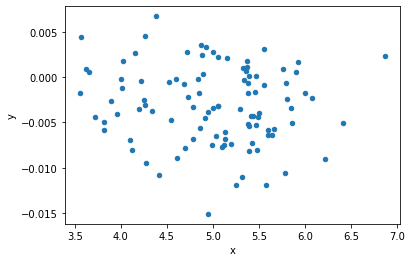

In [ ]:
vector_data.plot.scatter( x='x', y='y' )

In [ ]:
n_clusters = 4

kmeans = KMeans( n_clusters=n_clusters )

kmeans.fit( vector_data )

KMeans(n_clusters=4)

In [ ]:
predictions = kmeans.predict( vector_data )
K_means_data['cluster'] = predictions
K_means_data.head()

,word,x_values,y_values,count,x,y,cluster
0,drinking,6.215463,-0.009043,851,6.215463,-0.009043,2
1,day,5.762894,0.000861,626,5.762894,0.000861,2
2,years,5.389422,-0.008187,308,5.389422,-0.008187,0
3,like,6.412336,-0.005010,634,6.412336,-0.005010,2
4,last,4.987385,-0.007514,313,4.987385,-0.007514,1


In [ ]:
K_means_data['cluster'].value_counts()

0    32
1    31
3    24
2    13
Name: cluster, dtype: int64

In [ ]:
for i in range( 0, n_clusters ):
  print( "CLUSTER " + str( i ) + " WORDS:")
  the_dudes = K_means_data[K_means_data.cluster == i]
  print( the_dudes.word )

CLUSTER 0 WORDS:
2         years
6         sober
8           way
10         know
15        today
16      getting
17         home
21         also
23         beer
24         much
26        think
27         good
28       always
29        would
35        night
38       things
39     sobriety
43        could
44           go
50         days
54       around
55         year
57         made
59          one
62       really
67       people
73         even
79      started
81    something
82         went
85      feeling
91      anxiety
Name: word, dtype: object
CLUSTER 1 WORDS:
4         last
7        since
9         well
13       going
18         lot
20        help
22      anyone
25       every
30      months
36        want
37       drunk
41        love
45        back
47        need
52        long
58        stop
61    everyone
63        week
66      better
68         two
69       right
71        make
74       first
75         bad
80        felt
83         see
87       never
88        keep
93      

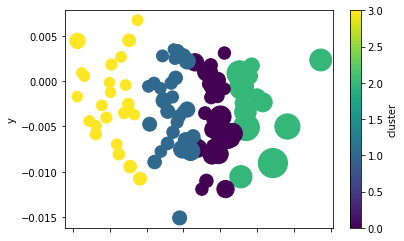

In [ ]:
K_means_data.plot.scatter( x='x', y='y', c='cluster', colormap='viridis', s='count' )